---
title: Borzoi eQTL Example
author: Johannes Linder, David R. Kelley
date: 9/20/2023
---

## Setup

In [1]:
import os
import time

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import baskerville
from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

import json

import pysam

import pyfaidx

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from borzoi_helpers import *


2023-09-20 21:36:27.557905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 21:36:30.375102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-20 21:36:34.863088: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
#Download model files and other dependencies (skip this cell if already executed once)

#Create model file structure
!mkdir saved_models
!mkdir saved_models/f0
!mkdir saved_models/f1
!mkdir saved_models/f2
!mkdir saved_models/f3

#Download model weights
!wget https://storage.googleapis.com/seqnn-share/borzoi/f0/model0_best.h5 -O saved_models/f0/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f1/model0_best.h5 -O saved_models/f1/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f2/model0_best.h5 -O saved_models/f2/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f3/model0_best.h5 -O saved_models/f3/model0_best.h5

#Download and uncompress annotation files
!wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
!wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
!wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz

#Download and index hg38 genome
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
pyfaidx.Faidx('hg38.fa')


--2023-09-19 17:48:11--  https://storage.googleapis.com/seqnn-share/borzoi/f0/model0_best.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.59, 142.250.190.123, 142.250.190.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744112468 (710M) [application/octet-stream]
Saving to: ‘saved_models/f0/model0_best.h5’

saved_models/f0/mod 100%[===================>] 709.64M  25.8MB/s    in 27s     

2023-09-19 17:48:39 (26.0 MB/s) - ‘saved_models/f0/model0_best.h5’ saved [744112468/744112468]

--2023-09-19 17:48:39--  https://storage.googleapis.com/seqnn-share/borzoi/f1/model0_best.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.59, 142.250.190.123, 142.250.190.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744112468 (710M) [applicat

Faidx("hg38.fa")

In [2]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 4       #To use only one model fold, change to 'n_folds = 1'
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, '0')
    
    models.append(seqnn_model)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 524288, 4)]  0           []                               
                                                                                                  
 stochastic_reverse_complement   ((None, 524288, 4),  0          ['sequence[0][0]']               
 (StochasticReverseComplement)   ())                                                              
                                                                                                  
 stochastic_shift (StochasticSh  (None, 524288, 4)   0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                           
                                                                                            

In [3]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load splice site annotation

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


## Predict Exon Coverage

In [4]:
#Load GTF (optional; needed to compute exon coverage attributions for example gene)

transcriptome = bgene.Transcriptome('gencode41_basic_nort.gtf')

search_gene = 'ENSG00000187164'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)


In [5]:
#Print index of GTEx blood and muscle tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("blood tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['local_index'].tolist()))
print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))


blood tracks = [9, 10, 11]
muscle tracks = [47, 48, 49]


-- Counts --
 - sum_wt = 127138.67
 - sum_mut = 126502.67
 - max_y_wt = 809.7634
 - max_y_mut = 810.978
 -- (max_y = 810.978)


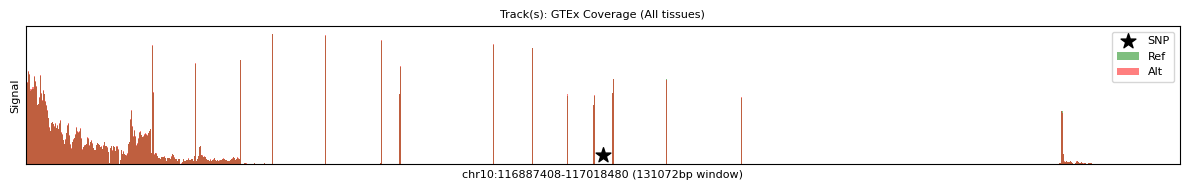

 - sum_wt = 43400.95
 - sum_mut = 53960.754
 - max_y_wt = 339.3114
 - max_y_mut = 423.4269
 -- (max_y = 423.4269)


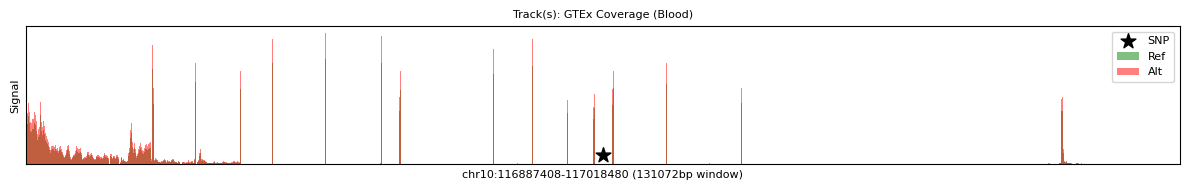

 - sum_wt = 32183.52
 - sum_mut = 33052.13
 - max_y_wt = 296.1789
 - max_y_mut = 302.3407
 -- (max_y = 302.3407)


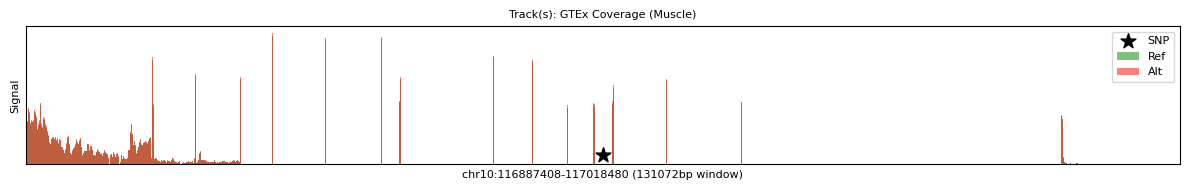

In [6]:
#Predict for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 131072
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [
    0.01,
    0.01,
    0.01,
]

track_transforms = [
    3./4.,
    3./4.,
    3./4.,
]

soft_clips = [
    384.,
    384.,
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(y_wt, y_mut, chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=1*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, gene_slice=gene_slice, anno_df=anno_df)


In [16]:
print("Output Shape:",y_wt.shape)
y_wt

Output Shape: (1, 4, 16352, 89)


array([[[[0.02048 , 0.0909  , 0.0631  , ..., 0.03622 , 0.04785 ,
          0.06726 ],
         [0.0208  , 0.0899  , 0.0629  , ..., 0.0378  , 0.04984 ,
          0.06885 ],
         [0.01758 , 0.0778  , 0.05542 , ..., 0.03442 , 0.04456 ,
          0.06064 ],
         ...,
         [0.001438, 0.003803, 0.003777, ..., 0.003843, 0.005497,
          0.004044],
         [0.001427, 0.003862, 0.003742, ..., 0.0039  , 0.005524,
          0.003975],
         [0.001422, 0.004257, 0.00394 , ..., 0.00432 , 0.00611 ,
          0.00428 ]],

        [[0.01269 , 0.0331  , 0.03102 , ..., 0.0242  , 0.03412 ,
          0.02678 ],
         [0.01817 , 0.0427  , 0.0419  , ..., 0.03146 , 0.04327 ,
          0.03528 ],
         [0.02103 , 0.0485  , 0.0469  , ..., 0.03714 , 0.05066 ,
          0.04117 ],
         ...,
         [0.01158 , 0.02269 , 0.02554 , ..., 0.01988 , 0.02858 ,
          0.02545 ],
         [0.00986 , 0.02061 , 0.02254 , ..., 0.01802 , 0.02547 ,
          0.02234 ],
         [0.01179 , 0.02

In [51]:
import importlib
import borzoi_helpers_sm
importlib.reload(borzoi_helpers_sm)
## GTEx blood tracks
track_index = [47, 48, 49]
y_wt_curr = borzoi_helpers_sm.inverse_transform(y_wt, 0.01, 3./4., 384.)
print("Sum (Expression Attribution):", borzoi_helpers_sm.expr_attr(y_wt, track_index, gene_slice))

Sum (Expression Attribution): 32183.52


## Score Variants

In [15]:
#Get contribution scores (gradient) for blood GTEX tracks

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    0,
    1,
    0,
    1,
    target_index[[9, 10, 11]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


The following Variables were used a Lambda layer's call (inp_grad), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/kernel:0' shape=(15, 4, 512) dtype=float32>
  <tf.Variable 'conv1d/bias:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/gamma:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'conv1d_1/kernel:0' shape=(5, 512, 608) dtype=float32>
  <tf.Variable 'conv1d_1/bias:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/gamma:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/beta:0' shape=(608,) dtype=float32>
  <tf.Variable 'conv1d_2/kernel:0' shape=(5, 608, 736) dtype=float32>
  <tf.Variable 'conv1d_2/bias:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/gamma:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/beta:0' shape=(736,) dtype=float32>
  <tf.Variable 'conv1d_3/ke

--- WT ---


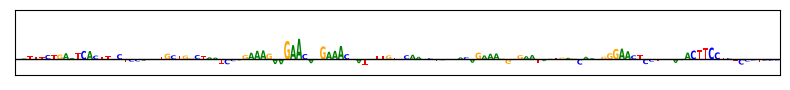

--- Mut ---


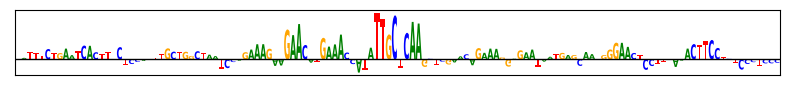

In [11]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [ ]:
#Get contribution scores (ISM) for blood GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    0,
    1,
    0,
    1,
    [9, 10, 11],
    0.01,
    3./4.,
    384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


--- WT ---


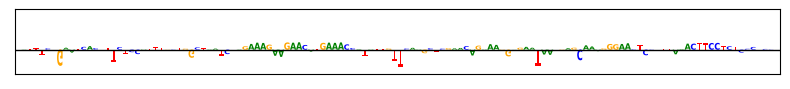

--- Mut ---


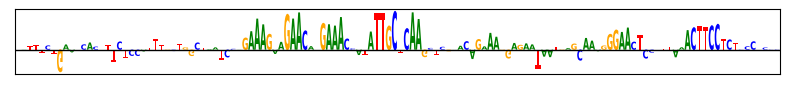

In [13]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [ ]:
#Get contribution scores (ISM shuffle) for blood GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    0,
    1,
    0,
    1,
    [9, 10, 11],
    0.01,
    3./4.,
    384.,
    window_size=7,
    n_samples=24,
    dinuc_shuffle=True,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


--- WT ---


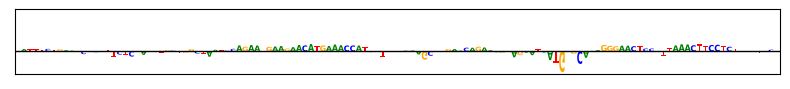

--- Mut ---


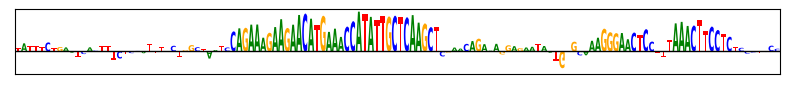

In [15]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [12]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 32)
gtex_targets_mut.shape = (16352, 32)
-- Counts --
 - sum_wt = 27668.607
 - sum_mut = 37653.69
 - max_y_wt = 241.0508
 - max_y_mut = 370.9016
 -- (max_y = 370.9016)


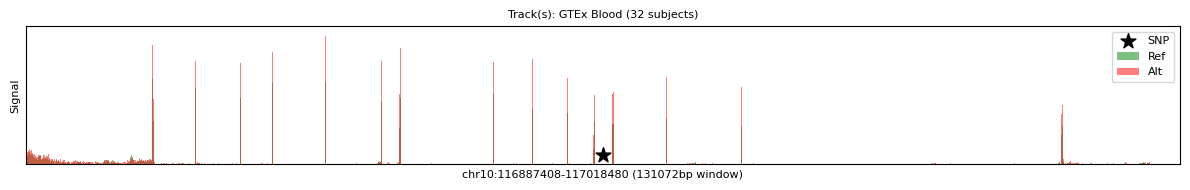

In [13]:
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C_meas_32_subjects'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 131072
bin_size = 32
pad = 16

anno_df = None #splice_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(32).tolist(),
]

track_names = [
    'GTEx Blood (32 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(gtex_targets_wt[None, None, ...], gtex_targets_mut[None, None, ...], chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=4*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, gene_slice=gene_slice, anno_df=anno_df)
